# RAVEN2YOLO

This Google Colab is a free to use tool used for a scientific publication created by Stéphane Chavin, Phd student in CIAN https://cian.lis-lab.fr at univ. Toulon, CNRS, LIS, granted by the AI Chair PI H. Glotin ADSIL ANR-20-CHIA-0014 Agence Nationale de la Recherche and DGA AID.

It aims to convert Raven annotations into YOLOv5 format and easily train a model based on these detections

The following lines will give a simple example. For details on the use of this method, see the publication : link_here

In this example, only X vocalizations has been used to reduce tutorial duration

In [ ]:
#@title Import all the scripts from the Git repo
# For the Git Repository, see : https://gitlab.lis-lab.fr/stephane.chavin/raven2yolo
!rm -rf sample_data/

!git clone https://gitlab.lis-lab.fr/stephane.chavin/raven2yolo.git


In [ ]:
#@title Install Requirements

# First : install the requirements
# This can take few seconds

!pip install -r /content/raven2yolo/requirements.txt


In [ ]:
def download(file_name: str, directory, suffix):
  """Download data from an online server
    :param file_name (str): Name of the file/folder to download
  """

  # /!\ change this if you want to download your data
  URL = 'https://sabiod.lis-lab.fr/pub/Humpback_Whale_CIAN/ColabTutorial/'
  source_url = os.path.join(URL,file_name)
  target_path = os.path.join(directory, file_name)
  response = requests.get(source_url)
  soup = BeautifulSoup(response.content, 'html.parser')
  file_links = soup.find_all('a')

  os.makedirs(target_path, exist_ok=True)
  for link in file_links:
      file_name = link.get('href')
      if file_name.endswith('/'):  # Skip directories
          continue
      elif file_name.endswith(suffix):
        file_url = os.path.join(source_url, file_name)
        target_file = os.path.join(target_path, file_name)

        print(f"Downloading file '{file_name}' from {source_url}")
        os.system(f"wget {file_url} -O {target_file}")
  print(f"Saved in {target_path} \n")


In [ ]:
#@title Download Raven annotations + corresponding .WAV files

import os
import requests
from bs4 import BeautifulSoup

directory = os.path.abspath('')
download('files', directory, 'WAV')
download('raven', directory, 'txt')


Saved in /content/files 

Saved in /content/raven 



In [ ]:
#@title Convert Raven annotations to YOLO format + split into train/val
# no test due to too small dataset for tutorial

# If you need a test, add --test in the command line ⚠️

# For the first input, please enter the suffix of your recordings files (here : WAV)
# For the second input please enter N

os.chdir('/content/raven2yolo')

!python get_train_annot.py /content/raven /content/files /content --duration 8 \
  --rf 9000 --window 256 --hop 0.5 --cpu 3 --cmap viridis --minimum False


In [ ]:
# Do not run this command if you answer Y or add --test before

# Split ratio is 70% train, 30% val

!python get_train_val.py /content/labels/ /content -r 0.7


Processing: 100% 21/21 [00:00<00:00, 774.97it/s]

    class  train ratio  val ratio
0    0.0     0.615385   0.384615
1    1.0     1.000000   0.000000
2    2.0     0.600000   0.400000
3    3.0          NaN        NaN
4    4.0     0.500000   0.500000
5    5.0     1.000000   0.000000
6    6.0          NaN        NaN
7    7.0          NaN        NaN
8    8.0          NaN        NaN
9    9.0          NaN        NaN
`/content/set` has been created
`/content/set/images` has been created
`/content/set/labels` has been created
`/content/set/images/train` has been created
`/content/set/images/val` has been created
`/content/set/images/test` has been created
`/content/set/labels/train` has been created
`/content/set/labels/val` has been created
`/content/set/labels/test` has been created

Your dataset is unbalanced ❌ you should use positive class weights in the custom_hyp.yaml cls_pw, add this [1.0, 2.3636363636363638, 2.888888888888889, 6.5, 6.5, 6.5, 6.5, 13.0, 13.0, 26.0]
Train saved in /conte

In [ ]:
#@title Download background noise, extract the spectrograms and move into training set

download('noise', directory, 'WAV')


Saved in /content/noise 



In [ ]:
!python get_spectrogram.py /content/noise /content --duration 8 --rf 9000 \
  --window 256 --hop 0.5 --background --cmap viridis --vmin False


Collect all files on a folder...
Processing:   0% 0/1 [00:00<?, ?it/s]`/content/background` has been created
Processing: 100% 1/1 [00:05<00:00,  5.02s/it]
Saved to /content/background


In [ ]:
# Copy the noise spectrograms into tre training set

!cp /content/background/*.jpg /content/set/images/train/.
!cp /content/background/*.txt /content/set/labels/train/.


In [ ]:
#@title Visualize the annotations

!pip install imageio[ffmpeg] Pillow


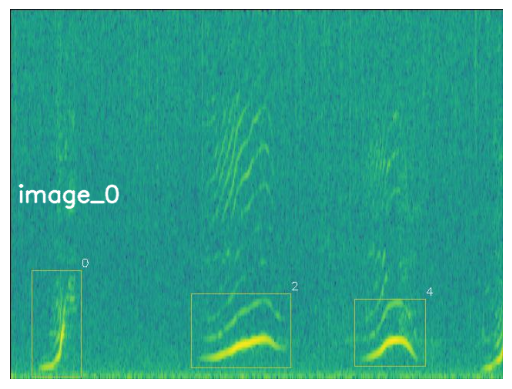

In [ ]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def process_images(folder):
    """
    Process images and store them with annotations text
    """
    annotated_images = []
    count = 0
    for image in glob.glob(os.path.join('/content/', folder, '*.jpg')):
        im0 = cv2.imread(image)
        if im0 is not None:
            text = f'image_{count}'
            x, y = 10, 250
            img_text = cv2.putText(im0, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                                   1, (255, 255, 255), 2, cv2.LINE_AA)
            annotated_images.append(cv2.cvtColor(img_text, cv2.COLOR_BGR2RGB))
            count += 1
    return annotated_images

def update(frame):
    """
    Update the animation
    """
    plt.imshow(annotated_images[frame])
    plt.axis('off')

# Process images
annotated_images = process_images('annotated_images')

# Ensure there are images to animate
if annotated_images:
    # Create a figure for the animation
    fig = plt.figure()

    # Create an animation
    anim = FuncAnimation(fig, update, frames=len(annotated_images), interval=300)

    # Save the animation as a GIF
    gif_path = '/content/animation.gif'
    anim.save(gif_path, writer=PillowWriter(fps=2))
else:
    print("No images found in the specified directory.")


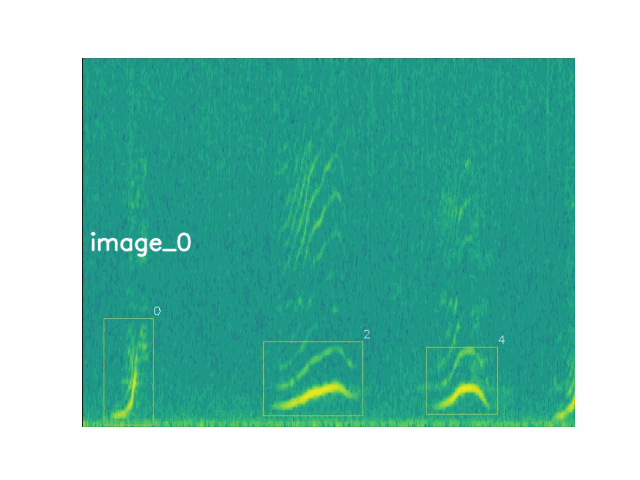

In [ ]:
# Display the animation
from IPython.display import Image

display(Image(gif_path))


---

## TRAIN THE MODEL

⚠️ If the training doesn't start and it says that the data are corrupted, launch again the cell ⚠️

In [ ]:
#@title Train the YOLOv5 (small version) model with your dataset

# INFORMATION : The output of the script get_train_val.py gives you a training command.
# You can copy this command and run as bellow.
# If you ran get_train_annot.py with --test, the command line is the final output

# For the paper, 1,894 annotations for 28 classes were used.
# In this Google Colab, there is not enough annotations to get a good trainning result

try:
  os.remove('/content/set/labels/train.cache')
except:
  pass

!python /content/raven2yolo/yolov5/train.py --data /content/set/custom_data.yaml \
  --imgsz 640 --epochs 5 --weights /content/raven2yolo/yolov5/weights/yolov5s.pt \
  --hyp /content/raven2yolo/custom_hyp.yaml --rf 9000 --duration 8 --cache \
  | tee /content/train_output.txt


2024-11-19 13:09:53.971835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 13:09:54.125311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 13:09:54.135696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 13:09:54.164476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 13:09:56.215854: W tensorflow/compiler/tf2

---

In [ ]:
#@title Detect on new recordings

download('new_data', directory, 'WAV')


Saved in /content/new_data 



In [ ]:
output = open('/content/train_output.txt', 'r')
train_output = output.read().split(' ')[-1][:-1]
output.close()

In [ ]:
!python /content/raven2yolo/yolov5/detect.py --weights \
  /content/raven2yolo/yolov5/runs/train/{train_output}/weights/best.pt \
  --imgsz 640 --conf 0.01 --source /content/new_data --save-txt --sound \
  --rf 9000 --sampleDur 8 --window 256 --hop 0.5 --high 30 --cmap viridis \
  --save-conf | tee /content/detect_output.txt


detect: weights=['/content/raven2yolo/yolov5/runs/train/TEST_20241119_s_640_SGD_9000_8_YOLOV5/weights/best.pt'], source=/content/new_data, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.01, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, sampleDur=8, rf=9000, low=None, high=30, cmap=viridis, window=256, hop=0.5, minimum=True, hide_conf=False, half=False, sound=True, dnn=False, vid_stride=1
Please enter the name of your project : essai
YOLOv5 🚀 2024-11-19 Python-3.10.12 torch-2.5.1+cu121 CPU

/content/raven2yolo/yolov5/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle dat

In [ ]:
output = open('/content/detect_output.txt', 'r')
detect_output = output.read().split(' ')[-1][:-2]
output.close()

In [ ]:
#@title Compile the detections and export in Raven format

# For the input, add your name

!python get_time_freq_detection.py \
  /content/raven2yolo/yolov5/runs/detect/{detect_output}/labels \
  /content /content/set/custom_data.yaml --rf 9000 \
  --path_to_wav /content/new_data/ --duration 8 --raven \
  | tee /content/time_freq_output.txt


Processing: 100% 5/5 [00:00<00:00, 496.51it/s]
`/content/Raven_annotation` has been created

Saving the Raven Annotations files...

Processing: 100% 1/1 [00:00<00:00, 261.38it/s]
Annotation saved in </content> as Raven_annotation
Your name : stp
Saved as /content/YOLO_detection_19_11_freq_9000_duration_8.nc


In [ ]:
output = open('/content/time_freq_output.txt', 'r')
time_freq_output = output.read().split(' ')[-1][:-1]
output.close()

In [ ]:
import xarray as xr

ds = xr.open_dataset(time_freq_output)
print('\n', ds) # NetCDF format


df = ds.to_dataframe()
print('\n', df) # Pandas DataFrame format

# data = ds.to_array()
# print('\n', data) # Xarray format



 <xarray.Dataset> Size: 2kB
Dimensions:         (index: 15)
Coordinates:
  * index           (index) int32 60B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Data variables: (12/16)
    file            (index) object 120B ...
    filename        (index) object 120B ...
    offset          (index) object 120B ...
    species         (index) object 120B ...
    class           (index) int32 60B ...
    x               (index) float64 120B ...
    ...              ...
    pos             (index) float64 120B ...
    Low Freq (Hz)   (index) float64 120B ...
    High Freq (Hz)  (index) float64 120B ...
    Begin Time (s)  (index) float64 120B ...
    End Time (s)    (index) float64 120B ...
    duration        (index) float64 120B ...
Attributes:
    title:         YOLO detection final table
    summary:       This dataset contains the YOLO detection with parameters.
    description:   The data includes positions : "pos", frequencies : "low fr...
    date_created:  2024-11-19T13:15:26.186814
    creat

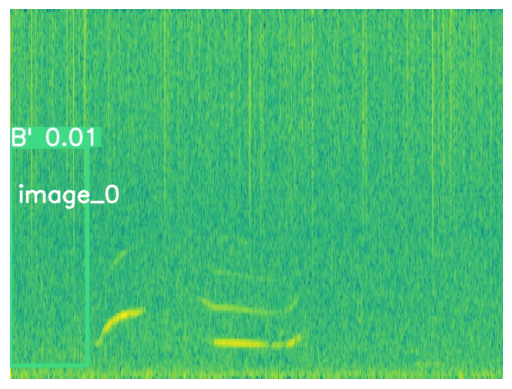

In [ ]:
#@title Visualize the Detections

folder_name = detect_output.split('/')[0]
# Process images
annotated_images = process_images(f'/content/raven2yolo/yolov5/runs/detect/{folder_name}')

# Ensure there are images to animate
if annotated_images:
    # Create a figure for the animation
    fig = plt.figure()

    # Create an animation
    anim = FuncAnimation(fig, update, frames=len(annotated_images), interval=300)

    # Save the animation as a GIF
    gif_path = '/content/animation_detection.gif'
    anim.save(gif_path, writer=PillowWriter(fps=2))
else:
    print("No images found in the specified directory.")


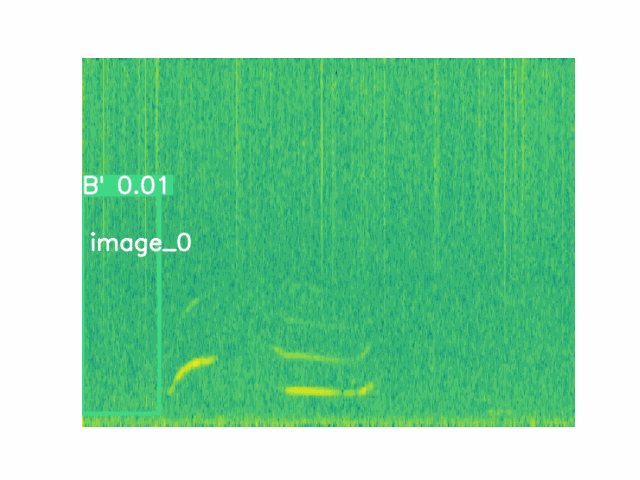

In [ ]:
display(Image(gif_path))

---


In [ ]:
# These are the weights from the paper

download('weights', directory, 'pt')
download('weights', directory, 'yaml')

Saved in /content/weights 

Saved in /content/weights 



In [ ]:
#@title Detect with the weights of the trainned classifier

!python /content/raven2yolo/yolov5/detect.py --weights /content/weights/best.pt \
  --imgsz 640 --conf 0.3 --source /content/new_data --save-txt --sound \
  --rf 9000 --sampleDur 8 --window 256 --hop 0.5 --cmap viridis \
  --save-conf --minimum False | tee /content/detect_weights_output.txt

detect: weights=['/content/weights/best.pt'], source=/content/new_data, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, sampleDur=8, rf=9000, low=None, high=None, cmap=viridis, window=256, hop=0.5, minimum=False, hide_conf=False, half=False, sound=True, dnn=False, vid_stride=1
Please enter the name of your project : tt
YOLOv5 🚀 2024-11-19 Python-3.10.12 torch-2.5.1+cu121 CPU

/content/raven2yolo/yolov5/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

In [ ]:
import xarray as xr

output = open('/content/detect_weights_output.txt', 'r')
detect_weights_output = output.read().split(' ')[-1][:-2]
output.close()

# For the input, add your name

!python get_time_freq_detection.py \
  /content/raven2yolo/yolov5/runs/detect/{detect_weights_output}/labels \
  /content /content/weights/custom_data.yaml --rf 9000 \
  --path_to_wav /content/new_data/ --duration 8 --raven \
  | tee /content/time_freq_weights_output.txt

output = open('/content/time_freq_weights_output.txt', 'r')
time_freq_weights_output = output.read().split(' ')[-1][:-1]
output.close()

Processing: 100% 7/7 [00:00<00:00, 407.62it/s]

Saving the Raven Annotations files...

Processing: 100% 1/1 [00:00<00:00, 170.48it/s]
Annotation saved in </content> as Raven_annotation
Your name : stp
Saved as /content/YOLO_detection_19_11_freq_9000_duration_8.nc



 <xarray.Dataset> Size: 2kB
Dimensions:         (index: 15)
Coordinates:
  * index           (index) int32 60B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Data variables: (12/16)
    file            (index) object 120B ...
    filename        (index) object 120B ...
    offset          (index) object 120B ...
    species         (index) object 120B ...
    class           (index) int32 60B ...
    x               (index) float64 120B ...
    ...              ...
    pos             (index) float64 120B ...
    Low Freq (Hz)   (index) float64 120B ...
    High Freq (Hz)  (index) float64 120B ...
    Begin Time (s)  (index) float64 120B ...
    End Time (s)    (index) float64 120B ...
    duration        (index) float64 120B ...
Attributes:
    title:         YOLO detection final table
    summary:       This dataset contains the YOLO detection with parameters.
    description:   The data includes positions : "pos", frequencies : "low fr...
    date_created:  2024-11-19T13:16:22.738934
    creat

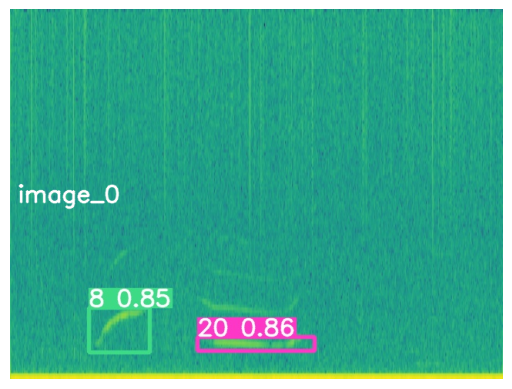

In [ ]:
ds = xr.open_dataset(time_freq_weights_output)
print('\n', ds) # NetCDF format


df = ds.to_dataframe()
print('\n', df) # Pandas DataFrame format

# data = ds.to_array()
# print('\n', data) # Xarray format

#@title Visualize the Detections

folder_name = detect_weights_output.split('/')[0]
# Process images
annotated_images = process_images(f'/content/raven2yolo/yolov5/runs/detect/{folder_name}')

# Ensure there are images to animate
if annotated_images:
    # Create a figure for the animation
    fig = plt.figure()

    # Create an animation
    anim = FuncAnimation(fig, update, frames=len(annotated_images), interval=300)

    # Save the animation as a GIF
    gif_path = '/content/animation_detection_weights.gif'
    anim.save(gif_path, writer=PillowWriter(fps=2))
else:
    print("No images found in the specified directory.")

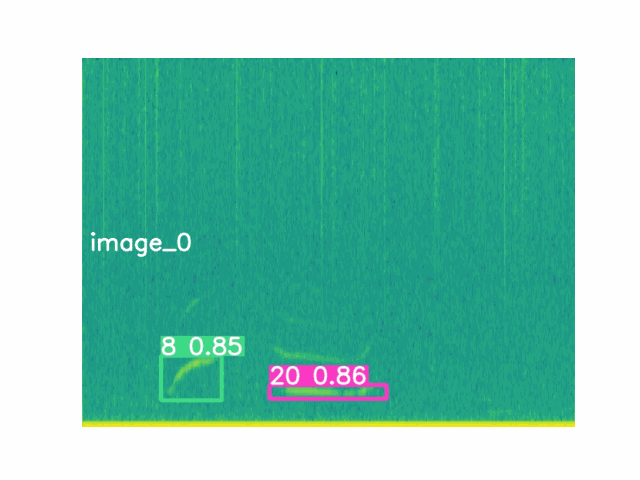

In [ ]:
display(Image(gif_path))